In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import re
import tensorflow as tf
from keras.callbacks import Callback, EarlyStopping
import numpy as np

In [78]:
MY_PC = '.'
MY_DRIVE = '/content/drive/MyDrive/KFUPM/ICS485 Machine Learning/machine-learning'


working_on = MY_PC

# Reading the data

In [79]:
train_data = pd.read_csv(working_on + "/preprocessed_data/train_data.csv")
val_data = pd.read_csv(working_on + "/preprocessed_data/val_data.csv")
test_data = pd.read_csv(working_on + "/preprocessed_data/test_data.csv")

In [80]:
train_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X14_ CA53,X14_ CA54,X14_ CA55,X14_ CA58,X14_ CA59,X14_ CA60,X15_R1,X15_R2,X15_R3,Y
0,-1.007786,-0.000544,0.924464,-0.697987,-0.334397,-0.826811,1.197546,-0.387438,-1.230982,0.333122,...,0,0,0,0,0,0,0,0,1,Mercedes
1,-1.514967,1.622085,-0.743079,-1.074390,-0.828481,-0.844427,-0.759763,0.589630,1.018781,-1.042734,...,0,0,0,0,0,0,0,0,1,Mercedes
2,-0.770762,1.050155,0.924464,0.684029,0.089103,-0.302898,-2.086752,1.141886,1.968222,-0.608345,...,0,0,0,0,0,0,0,1,0,Mercedes
3,-0.087724,0.018637,0.257447,0.616613,0.142041,0.029527,0.733100,0.802036,-0.157701,0.778896,...,0,0,0,0,0,0,0,1,0,Honda
4,1.102495,-0.000544,0.257447,-0.905851,-0.581439,0.422461,-1.257384,-0.514882,0.729820,1.578486,...,0,0,0,0,0,0,0,1,0,Toyota


,Column,Non-Null Count,Dtype,Unique Values
Y,Y,4259,object,6
X1,X1,4259,float64,1294
X2,X2,4259,float64,361
X3,X3,4259,float64,49
X4,X4,4259,float64,225
X5,X5,4259,float64,301
X6,X6,4259,float64,1677
X7,X7,4259,float64,164
X8,X8,4259,float64,133
X9,X9,4259,float64,241


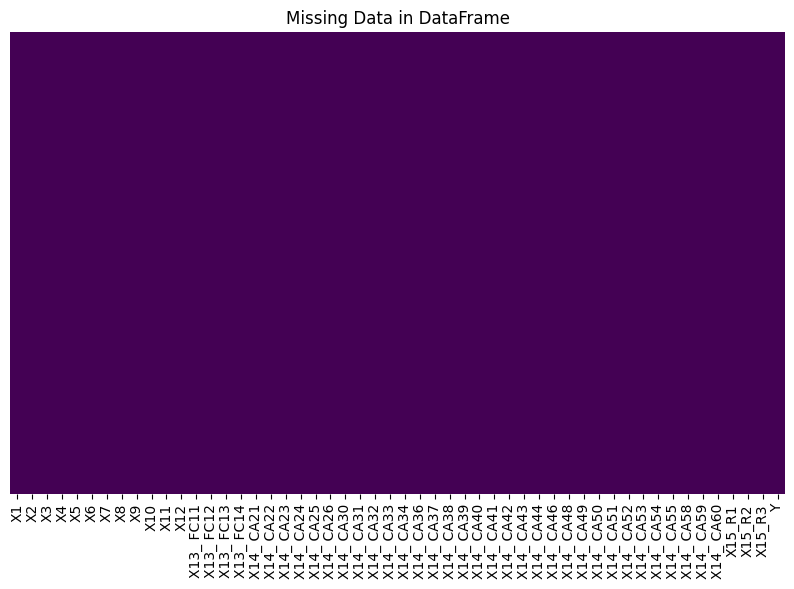

In [81]:
def display_dataframe_summary(dataframe, sort_by='Column'):

    summary = pd.DataFrame({
        'Column': dataframe.columns,
        'Non-Null Count': dataframe.notnull().sum(),
        'Dtype': dataframe.dtypes,
        'Unique Values': dataframe.nunique()
    })

    # Extracting numerical part from column names for sorting
    summary['Sort Key'] = summary['Column'].apply(lambda x: int(re.search(r'\d+', x).group()) if re.search(r'\d+', x) else 0)

    # Sorting the summary DataFrame
    if sort_by == 'Column':
        summary = summary.sort_values(by='Sort Key', ascending=True)
    else:
        summary = summary.sort_values(by=sort_by, ascending=True)

    summary = summary.drop('Sort Key', axis=1)  # Remove the auxiliary sort key column

    # Display the summary
    display(summary)

    # Plotting missing data
    plt.figure(figsize=(10, 6))
    sns.heatmap(dataframe.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.title('Missing Data in DataFrame')
    plt.show()

# Call the function with your DataFrame
display_dataframe_summary(train_data, sort_by='Column')


In [82]:
X_train = train_data.drop('Y', axis=1).to_numpy()
y_train = pd.get_dummies(train_data['Y'], dtype='float32').to_numpy()

X_val = val_data.drop('Y', axis=1).to_numpy()
y_val = pd.get_dummies(val_data['Y'], dtype='float32').to_numpy()

X_test = test_data.drop('Y', axis=1).to_numpy()
y_test = pd.get_dummies(test_data['Y'], dtype='float32').to_numpy()


In [83]:
y_train

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [84]:
classes = train_data["Y"].unique()
num_classes = y_train.shape[1]
input_features = X_train.shape[1]
categorical_cols = train_data.select_dtypes(include=['object', 'category']).columns

print(f"The classes is: {classes}")
print(f"Number of classes: {num_classes}")
print(f"Number of features: {input_features}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}" )

print(categorical_cols)

The classes is: ['Mercedes' 'Honda' 'Toyota' 'BMW' 'GMC' 'Ford']
Number of classes: 6
Number of features: 51
X_train shape: (4259, 51), y_train shape: (4259, 6)
Index(['Y'], dtype='object')


# Building Model

In [85]:
# define the CNN model using Sequential method
from keras import Input, Model
from keras.layers import Dense
from keras.metrics import Precision, F1Score



def build_model(input_features, num_classes):
    # Create model
    input_data = Input(shape=(input_features,))
    x = Dense(64, activation='relu')(input_data)
    x = Dense(128, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_data, outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[F1Score(average="weighted")])

    return model



model = build_model(input_features, num_classes)

# Model summary
model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 51)]              0         
                                                                 
 dense_85 (Dense)            (None, 64)                3328      
                                                                 
 dense_86 (Dense)            (None, 128)               8320      
                                                                 
 dense_87 (Dense)            (None, 32)                4128      
                                                                 
 dense_88 (Dense)            (None, 16)                528       
                                                                 
 dense_89 (Dense)            (None, 6)                 102       
                                                                 
Total params: 16406 (64.09 KB)
Trainable params: 16406 (64

In [86]:
class PrintMetricsEveryNEpochs(Callback):
    def __init__(self, n_epochs=5):
        self.n_epochs = n_epochs

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.n_epochs == 0:
            print(f"Epoch {epoch + 1}:")
            for metric, value in logs.items():
                print(f"{metric}: {value:.4f}")

            print()


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=True,
    mode='min',
    restore_best_weights=True
)


# Create an instance of the custom callback
print_metrics = PrintMetricsEveryNEpochs(n_epochs=5)

# Include this callback in your model.fit call along with EarlyStopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    verbose=False,
    epochs=1000,
    batch_size=32,
    callbacks=[early_stopping, print_metrics]  # Add the custom callback
)


Epoch 5:
loss: 0.2730
f1_score: 0.8896
val_loss: 0.2834
val_f1_score: 0.8850

Epoch 10:
loss: 0.1976
f1_score: 0.9231
val_loss: 0.2413
val_f1_score: 0.9103

Epoch 15:
loss: 0.1319
f1_score: 0.9503
val_loss: 0.2320
val_f1_score: 0.9155

Epoch 20:
loss: 0.1059
f1_score: 0.9630
val_loss: 0.2541
val_f1_score: 0.9143

Epoch 25:
loss: 0.0792
f1_score: 0.9720
val_loss: 0.2674
val_f1_score: 0.9197

Epoch 30:
loss: 0.0649
f1_score: 0.9777
val_loss: 0.2894
val_f1_score: 0.9278

Restoring model weights from the end of the best epoch: 15.
Epoch 35:
loss: 0.0519
f1_score: 0.9807
val_loss: 0.2963
val_f1_score: 0.9201

Epoch 35: early stopping


In [87]:
# Final evaluation of the model
loss, acc = model.evaluate(X_test, y_test)
print("Test F1 Score: %.2f%%" % (acc*100))

29/29 [==============================] - 0s 821us/step - loss: 0.2700 - f1_score: 0.9032
Test F1 Score: 90.32%


In [88]:


# Get predictions for the validation set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

report = classification_report(y_true_classes, y_pred_classes, target_names=classes)
print(report)


29/29 [==============================] - 0s 714us/step
              precision    recall  f1-score   support

    Mercedes       0.92      0.95      0.93       242
       Honda       0.83      0.59      0.69        17
      Toyota       0.86      0.88      0.87        49
         BMW       0.87      0.83      0.85       169
         GMC       0.91      0.95      0.93       257
        Ford       0.92      0.90      0.91       185

    accuracy                           0.90       919
   macro avg       0.89      0.85      0.86       919
weighted avg       0.90      0.90      0.90       919



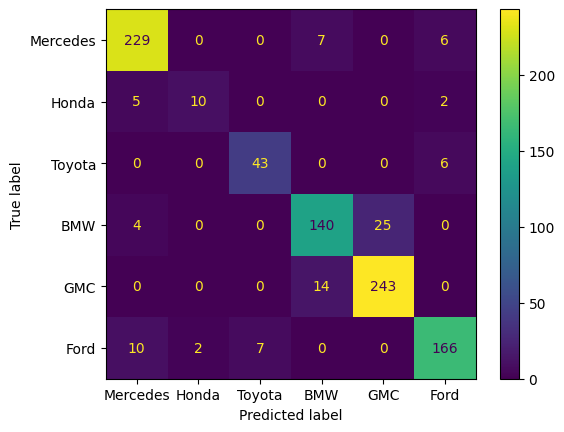

In [89]:
confusion_matrix = confusion_matrix(y_true_classes, y_pred_classes)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = classes)

cm_display.plot()
plt.show()